In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt

# DP Formula
# V[x] = max(0, [xp + (1-x)q] V(x_win) + [x(1-p) + (1-x)(1-q)] V(x_lose) + [xp + (1-x)q] - c ))

In [2]:
roundfactor = 4

def update_prior(x,p,q,c,result):
    if result == True:
        out = p*x/(win(x,p,q))
    else:
        out = (1 - p)*x/(lose(x,p,q))
    return round(out,roundfactor)

def expected_outcome(x,p,q,c):
    out = win(x,p,q) - c
    return round(out,roundfactor)

def win(x,p,q):
    return x*p + (1-x)*q

def lose(x,p,q):
    return x*(1-p) + (1-x)*(1-q)

def split_recurrence_single(x,p,q,c, delta, high, low, V_dict, Sym_dict, debug = False):
    if debug:
        print("---at", x)
    
    # need to check for rounding error
    for i in range(-3,4,1):
        if x + i/10000 in Sym_dict:
            x = x + i/10000
            break
    
    if x in V_dict:
        return V_dict[x], V_dict, Sym_dict
    if x in Sym_dict:
        return Sym_dict[x], V_dict, Sym_dict
    elif x < low:
        V_dict[x] = 0
        temp = Symbol("var" + str(x))
        Sym_dict[x] = temp
        return 0, V_dict, Sym_dict
    elif x > high:
        V_dict[x] = round(expected_outcome(1,p,q,c)/(1 - delta), 4)
        temp = Symbol("var" + str(x))
        Sym_dict[x] = temp
        return V_dict[x], V_dict, Sym_dict
    else:
        temp = Symbol("var" + str(x))
        Sym_dict[x] = temp
        
        c_0 = expected_outcome(x,p,q,c)
        
        p_w = win(x,p,q)
        x_w = update_prior(x,p,q,c,True)
        
        p_l = lose(x,p,q)
        x_l = update_prior(x,p,q,c,False)
        
        s_1, V_dict, Sym_dict = split_recurrence_single(x_w,p,q,c,delta,high,low,V_dict,Sym_dict)
        s_2, V_dict, Sym_dict = split_recurrence_single(x_l,p,q,c,delta,high,low,V_dict,Sym_dict)
        
        out = delta*p_w*s_1 + delta*p_l*s_2 + c_0 # V[x] formula
        
        V_dict[x] = out
        return out, V_dict, Sym_dict
    
def solve_split_recurrence(x,p,q,c,delta,high,low, debug = False):
    V_dict = {}
    Sym_dict = {}
    val, V_dict, Sym_dict = split_recurrence_single(x,p,q,c,delta,high,low, V_dict, Sym_dict)
    
    if debug:
        print('---HELLO---')
        print("max possible value", round(expected_outcome(1,p,q,c)/(1 - delta), 4))

    t_dict = {}
    for k in V_dict:
        if debug:
            print(k,V_dict[k], Sym_dict[k])
        if k in Sym_dict:
            t_dict[k] = V_dict[k] - Sym_dict[k]

#     print(t_dict.values, Sym_dict.values())
#     return t_dict, Sym_dict

    ans = list(linsolve(tuple(t_dict.values()), tuple(Sym_dict.values())))[0]
    
    key_list = list(Sym_dict.keys())
    x_plot = []
    y_plot = []
    bad = 0
    for i in range(len(key_list)):
#         print(i, key_list[i])
        if ans[i] < 0: 
            bad = max(bad, key_list[i])
            if debug: print("WARNING v < 0",key_list[i],ans[i],bad)
        x_plot.append(key_list[i])
        y_plot.append(ans[i])
            
    return x_plot, y_plot, bad

In [11]:
def find_x_star(p,q,c,delta):
    high = 0.99
    low = 0
    search = [0.5, 0.51, 0.62, 0.53, 0.64, 0.55, 0.66, 0.57, 0.68, 0.59]
    
    has_negative = True
    while has_negative:
        
        bad = 0
        for x_temp in search:
            _,_, temp_bad = solve_split_recurrence(x_temp, p,q,c,delta,high,low)
            bad = max(bad, temp_bad)
        if bad == 0:
            has_negative = False
        elif bad > 0:
            low = (low + bad)/2+0.01 # binary search and precision
    
    return low
        
def find_x_star_2(p,q,c,x,delta):
    high = 0.99
    low = 0
    search = [x]
    
    has_negative = True
    while has_negative:
        
        bad = 0
        for x_temp in search:
            _,_, temp_bad = solve_split_recurrence(x_temp, p,q,c,delta,high,low)
            bad = max(bad, temp_bad)
#         print(bad)
        if bad == 0:
            has_negative = False
        elif bad > 0:
            low = (low + bad)/2+0.01 # binary search and precision
    
    losses = 0
    while x > low:
#         print(x)
        x = update_prior(x,p,q,c,False)
        losses += 1
    x = update_prior(x,p,q,c,True)
    
    return x, losses-1

In [12]:
p = 0.6
q = 0.4
c2 = 0.45
delta = 0.9

priors = [c2 + 0.005*i for i in range(109)]
x_stars = []
for x in priors:
    x2, losses = find_x_star_2(p,q,c2,x, delta)
    x_stars.append(x2)
    print(x,x_stars[-1],losses)

# print(production_prices, x_stars)
# x_stars.append(0.1846) # for x = 1

0.45 0.1951 3
0.455 0.1984 3
0.46 0.2015 3
0.465 0.2048 3
0.47000000000000003 0.1491 4
0.47500000000000003 0.1515 4
0.48 0.1542 4
0.485 0.1569 4
0.49 0.1595 4
0.495 0.1622 4
0.5 0.165 4
0.505 0.1677 4
0.51 0.1705 4
0.515 0.1734 4
0.52 0.1763 4
0.525 0.1793 4
0.53 0.182 4
0.535 0.1852 4
0.54 0.1882 4
0.545 0.1913 4
0.55 0.1946 4
0.555 0.1976 4
0.56 0.2008 4
0.5650000000000001 0.2042 4
0.5700000000000001 0.1486 5
0.575 0.1511 5
0.5800000000000001 0.1538 5
0.585 0.1565 5
0.5900000000000001 0.1594 5
0.595 0.162 5
0.6 0.165 5
0.605 0.1678 5
0.61 0.1707 5
0.615 0.1738 5
0.62 0.1767 5
0.625 0.1799 5
0.63 0.1832 5
0.635 0.1864 5
0.64 0.1897 5
0.645 0.1931 5
0.65 0.1965 5
0.655 0.2001 5
0.66 0.2036 5
0.665 0.1484 6
0.67 0.1511 6
0.675 0.1542 6
0.68 0.1573 6
0.685 0.1603 6
0.69 0.1635 6
0.6950000000000001 0.1667 6
0.7 0.1701 6
0.7050000000000001 0.1734 6
0.71 0.1767 6
0.7150000000000001 0.1805 6
0.72 0.1842 6
0.7250000000000001 0.188 6
0.73 0.1919 6
0.7350000000000001 0.1959 6
0.74 0.1999 6
0.74

In [24]:
production_prices = [0.4 + 0.005*i for i in range(20)]
x_stars = []
for price in production_prices:
    x_stars.append(find_x_star(0.6, 0.4, price, 0.9))
    print(price,x_stars[-1])

# print(production_prices, x_stars)

new round 0
bad 0
0.4 0
new round 0
bad 0.0244
new round 0.0222
bad 0
0.405 0.0222
new round 0
bad 0.0492
new round 0.0346
bad 0
0.41000000000000003 0.0346
new round 0
bad 0.072
new round 0.046
bad 0
0.41500000000000004 0.046
new round 0
bad 0.0969
new round 0.05845
bad 0
0.42000000000000004 0.05845
new round 0
bad 0.1205
new round 0.07024999999999999
bad 0
0.42500000000000004 0.07024999999999999
new round 0
bad 0.1486
new round 0.0843
bad 0
0.43000000000000005 0.0843
new round 0
bad 0.1705
new round 0.09525
bad 0.0969
new round 0.10607499999999999
bad 0
0.43500000000000005 0.10607499999999999
new round 0
bad 0.1945
new round 0.10725
bad 0.1122
new round 0.11972499999999998
bad 0
0.44 0.11972499999999998
new round 0
bad 0.2213
new round 0.12065
bad 0.1292
new round 0.13492500000000002
bad 0
0.445 0.13492500000000002
new round 0
bad 0.2437
new round 0.13185
bad 0.1456
new round 0.148725
bad 0
0.45 0.148725
new round 0
bad 0.2659
new round 0.14295000000000002
bad 0.165
new round 0.163975

WARNING v < 0 0.4 -0.0487953012423154 0.4
WARNING v < 0 0.3077 -0.147016630786712 0.4
WARNING v < 0 0.2286 -0.182099043331129 0.4
WARNING v < 0 0.165 -0.137963997186141 0.4
WARNING v < 0 0.4096 -0.0329798476856800 0.4096
WARNING v < 0 0.3162 -0.134356961096205 0.4096
WARNING v < 0 0.2356 -0.173483565836339 0.4096
WARNING v < 0 0.1705 -0.133678294336599 0.4096
WARNING v < 0 0.4203 -0.0150547006738300 0.4203
WARNING v < 0 0.3259 -0.119816612066632 0.4203
WARNING v < 0 0.2437 -0.163531200472692 0.4203
WARNING v < 0 0.3258 -0.119819284643628 0.4203
WARNING v < 0 0.1768 -0.128675449094012 0.4203
WARNING v < 0 0.4291 -0.000593217225093740 0.4291
WARNING v < 0 0.3338 -0.107985641419969 0.4291
WARNING v < 0 0.2504 -0.155311430240257 0.4291
WARNING v < 0 0.1821 -0.124602912946908 0.4291
WARNING v < 0 0.345 -0.0913112387522435 0.345
WARNING v < 0 0.2599 -0.143709771615987 0.345
WARNING v < 0 0.1897 -0.118742631643355 0.345
WARNING v < 0 0.352 -0.0809074141645153 0.352
WARNING v < 0 0.2659 -0.136

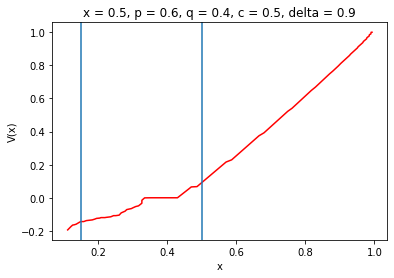

In [15]:
x_tot = []
y_tot = []
high, low = 0.99, 0.15

delta = 0.9 # discount rate
x = 0.5
p = 0.6
q = 0.4
c = 0.5
debug = False # set true to see equations


bad = 0
for x_temp in [0.5, 0.51, 0.62, 0.53, 0.64, 0.55, 0.66, 0.57, 0.68, 0.59]:
    x_plot, y_plot, temp_bad = solve_split_recurrence(x_temp, p,q,c,delta,high,low, debug)
    bad = max(bad, temp_bad)
    x_tot += x_plot
    y_tot += y_plot

print('is it bad', bad)
    
min_x = 1
for i in range(len(x_tot)):
    if y_tot[i] > 0 and x_tot[i] < min_x:
        min_x = x_tot[i]

print("min x is", min_x)

x_tot = sorted(x_tot)
y_tot = sorted(y_tot)

plt.plot(x_tot, y_tot,'r')
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title(f'x = {x}, p = {p}, q = {q}, c = {c}, delta = {delta}')
plt.axvline(x=low)
plt.axvline(x=(c-q)/(p-q))
plt.show()

In [18]:
p = 0.6
q = 0.4
c2 = 0.41
delta = 0.9

priors = [c2 + 0.005*i for i in range(109)]
x_stars = []
for x in priors:
    x2, losses = find_x_star_2(p,q,c2,x, delta)
    x_stars.append(x2)
    print(x,x_stars[-1],losses)

0.41 0.0391 7
0.415 0.0398 7
0.42 0.0407 7
0.425 0.0414 7
0.43 0.0423 7
0.435 0.0432 7
0.43999999999999995 0.044 7
0.44499999999999995 0.0449 7
0.44999999999999996 0.0456 7
0.45499999999999996 0.0467 7
0.45999999999999996 0.0474 7
0.46499999999999997 0.0484 7
0.47 0.0494 7
0.475 0.034 8
0.48 0.0348 8
0.485 0.0356 8
0.49 0.0362 8
0.495 0.0367 8
0.5 0.0376 8
0.505 0.0384 8
0.51 0.0389 8
0.515 0.0398 8
0.52 0.0405 8
0.525 0.0414 8
0.53 0.0421 8
0.5349999999999999 0.043 8
0.54 0.0438 8
0.5449999999999999 0.0446 8
0.55 0.0455 8
0.5549999999999999 0.0464 8
0.5599999999999999 0.0472 8
0.565 0.0483 8
0.57 0.0491 8
0.575 0.034 9
0.58 0.0347 9
0.585 0.0353 9
0.59 0.0362 9
0.595 0.0367 9
0.6 0.0376 9
0.605 0.0384 9
0.61 0.0391 9
0.615 0.04 9
0.62 0.0407 9
0.625 0.0416 9
0.63 0.0424 9
0.635 0.0433 9
0.64 0.0442 9
0.645 0.0451 9
0.6499999999999999 0.0459 9
0.655 0.0471 9
0.6599999999999999 0.0481 9
0.665 0.0491 9
0.6699999999999999 0.034 10
0.675 0.0348 10
0.6799999999999999 0.0356 10
0.685 0.0363 

In [20]:
find_x_star_2(0.6,0.4,0.45,0.565, 0.9)

(0.2042, 4)